# 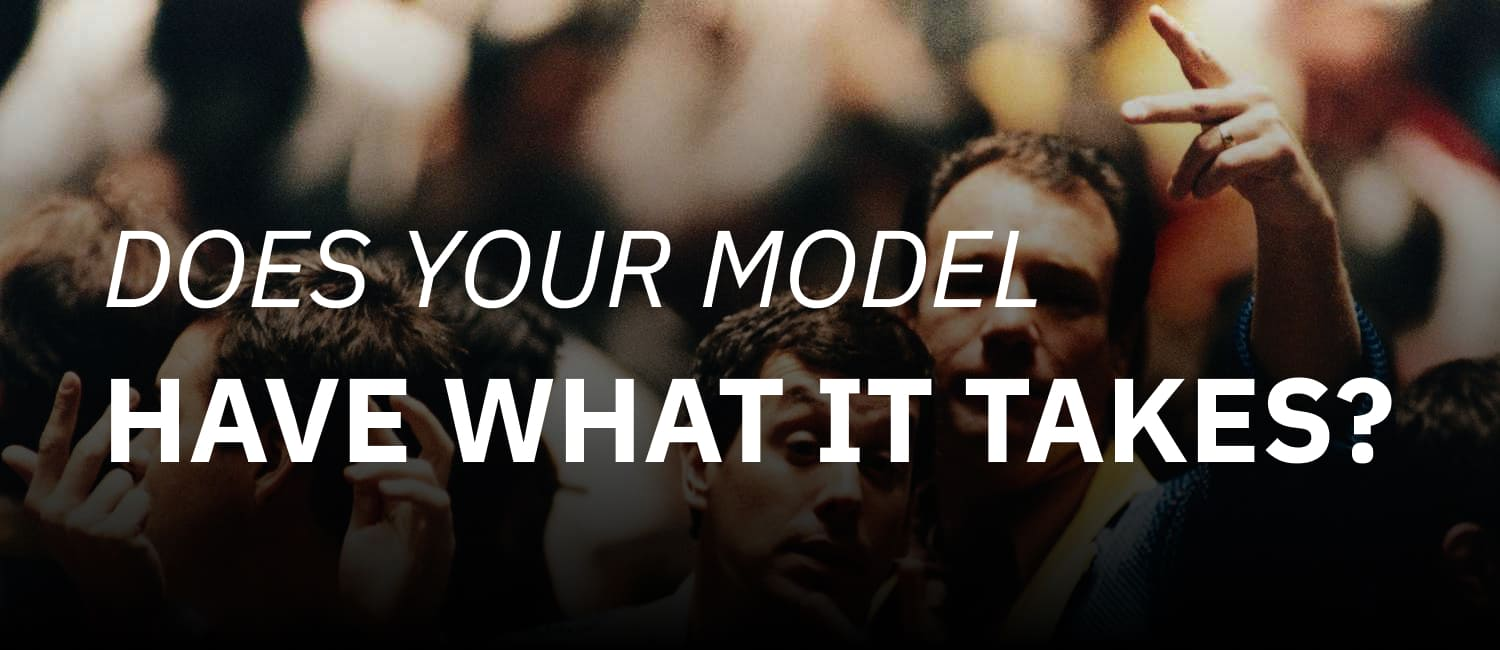

# Abstract

This notebook is a quickstarter for DataCrunching. It is a collection of code snippets and explanations to get you started with the DataCrunch code competition. It should give you a good starting point to understand how to work with the Crunch Foundation infrastructure.

It shows how to load the data, how to create a submission file and how to submit it.

The main goal of this notebook is to show how to make use of the function `crunch.alpha_score()` through the API in the context of your Machine Learning modeling. This function is used to calculate the scores of a prediction dataframe. It returns the score as calculated by the Crunch Foundation, with the un-obfuscated target and the same prediction transformations.

The cumulative product of this metric has an 84% correlation with the DataCrunch fund performance. This is to be compared with the 60% correlation of the spearman metric: it is reasonable to anticipate, [ceteris paribus](https://en.wikipedia.org/wiki/Ceteris_paribus), a 40% increase in the post-execution performance of the DataCrunch competition! We therefore believe this is a major step towards a more realistic and fair evaluation of the performance of the participants.

The scores on the leaderboard will be computed using the exact same prediction transformations and un-obfuscated target; this makes it possible for you to cross-validate your models against the actual scoring function and obtain reasonable expectations about your Out-of-Sample performance, defined by the scoring metric.

# Environment setup

Get your environment setup command on the following link: http://hub.crunchdao.com/competitions/datacrunch-rally/submit

In [12]:
# Install
%pip install crunch-cli --upgrade
!crunch setup datacrunch-rally . --token p7dZYGZd8RsdYW0JMU6vjxPSPFQggzfRW6vWCb3kc47vFvzK7fpRXe --force # <- replace with your token: https://hub.crunchdao.com/competitions/datacrunch-rally/submit/via/notebook


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

---
Your token seems to have expired or is invalid.

Please follow this link to copy and paste your new setup command:
https://hub.crunchdao.com/competitions/datacrunch-rally/submit

If you think that is an error, please contact an administrator.


# Import

**IMPORTANT**: For each library import, in order to avoid any issue related to the library version, it is strongly recommended to specify the version of the library you are using. This to ensure that the notebook will be reproducible in the Crunch Foundation environment without any undesirable modification to the behavior of your code.

If you submit through the cli, fill the `requirements.txt` with the libraries used and their respective versions.

In [13]:
# Install the necessary packages
%pip install readwrite
#%pip install [package_name]


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [14]:
# Imports
import os

# Specify the library version with the `==` operator. Follow the examples below for any other library added.
# You can get the version of the library you are using by running the command `!pip show <library_name>`, or '!pip freeze | grep <library_name>'.
# If you submit a .py file, you can add the library version to the requirements.txt file.
import joblib # == 1.3.2
import pandas as pd # == 2.1.0
import numpy as np # == 1.24.3
import xgboost as xgb # == 2.0.0
import crunch # == 3.0.0
import readwrite as rw # == 0.5.1
from tqdm import tqdm # == 4.64.1
import matplotlib.pyplot as plt # == 3.6.3

# Get the data

In [15]:
# Getting the data
crunch = crunch.load_notebook()
X_train, y_train, X_test = crunch.load_data()

loaded inline runner with module: <module '__main__'>
download data/X_train.parquet from https://crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/33/X_train.parquet (88467892 bytes)
already exists: file length match
download data/y_train.parquet from https://crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/33/y_train.parquet (3120772 bytes)
already exists: file length match
download data/X_test.parquet from https://crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/33/X_test_reduced.parquet (2353754 bytes)
already exists: file length match
download data/y_test.parquet from https://crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/33/y_test_reduced.parquet (77379 bytes)
already exists: file length match
download data/example_prediction.parquet from https://crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/33/example_prediction_reduced.parquet (95117 bytes)
a

# Train

The train function that will be called by the Crunch platform is defined below.

This function will be called in a frequency that is defined by your `training frequency` parameter that you will define when deploying your model on the Crunch platform.

In [16]:
# Uncomment the parameter(s) that you need!
def train(
    X_train: pd.DataFrame,
    y_train: pd.DataFrame,
    number_of_features: int,
    model_directory_path: str,
    id_column_name: str,
    moon_column_name: str,
    # target_column_name: str,
    prediction_column_name: str,
    # moon: int,
    embargo: int,
    # has_gpu: bool,
) -> None:
    """
    Do your model training here.
    At each retrain this function will have to save an updated version of
    the model under the model_directiory_path, as in the example below.
    Note: You can use other serialization methods than joblib.dump(), as
    long as it matches what reads the model in infer().

    Args:
        X_train, y_train: the data to train the model.
        number_of_features: the number of features of the dataset.
        model_directory_path: the path to save your updated model.
        id_column_name: the name of the id column.
        moon_column_name: the name of the moon column.
        target_column_name: the name of the target column.
        prediction_column_name: the name of the prediction column.
        moon, current_moon: the moon currently being processed.
        embargo: data embargo.
        has_gpu: if the runner has a gpu.

    Returns:
        None
    """
    target_column_name = 'target_w'
    
    features_columns = [column for column in X_train.columns if'Feature' in column]

    # Train-Validation split (80-20%)
    moons = X_train[moon_column_name].unique()
    moon_split = moons[int(len(moons) * 0.8)]
    
    Xtrain = X_train.loc[X_train[moon_column_name] < moon_split - embargo].set_index([moon_column_name, id_column_name])
    ytrain = y_train.loc[X_train[moon_column_name] < moon_split - embargo]

    Xval = X_train.loc[X_train[moon_column_name] >= moon_split].set_index([moon_column_name, id_column_name])
    yval = y_train.loc[X_train[moon_column_name] >= moon_split]

    # Create DMatrix objects for the training and validation sets
    dtrain = xgb.DMatrix(Xtrain, label=ytrain[target_column_name])
    dval = xgb.DMatrix(Xval, label=yval[target_column_name])

    def cumulative_product_alpha_score(preds, dmat):
        """
        Scoring function associated to the competition.
        The alpha score function details can be found in the documentation: https://app.gitbook.com/o/RB633hrgkrGuKJC9yruJ/s/bdufLVkgajcmVMIaXaw1/the-tournament/evaluation
        """
        if preds.shape[0] == Xval.shape[0]:
            preds_df = pd.DataFrame(preds, index=Xval.index, columns=[prediction_column_name])
            merged_df = pd.concat([Xval[[]], preds_df], axis=1)
        else:
            preds_df = pd.DataFrame(preds, index=Xtrain.index, columns=[prediction_column_name])
            merged_df = pd.concat([Xtrain[[]], preds_df], axis=1)

        # API call to compute the alpha score
        alpha_score = crunch.alpha_score(merged_df.reset_index())

        # Compute the cumulative product of the alpha score. This is the metric we want to maximise. Can be changed for another metric (eg. sharpe).
        cumprod = np.cumprod(alpha_score + 1) - 1

        return 'cumprod_alpha_score', -cumprod.iloc[-1] # Return the negative value as the custom metric is minimized

    # Define hyperparameters for XGBoost model
    params = {
        'objective': 'reg:squarederror',
        'max_depth': 1,
        'eta': 0.05,
        'subsample': 1,
        'colsample_bytree': 0.1,
    }

    # Specify the validation set for early stopping
    evals = [(dtrain, 'train'), (dval, 'eval')]

    # Run the model
    model = xgb.train(params, dtrain, evals=evals, custom_metric=cumulative_product_alpha_score, early_stopping_rounds=10)

    # Save the model
    joblib.dump(
        model,
        os.path.join(model_directory_path, "model.joblib")
    )

# Infer

The `infer` function that will be called by the Crunch platform is defined below.

This function will be called on every `moon` of the `Out-Of-Sample`.

In [17]:
# Uncomment the parameter(s) that you need!
def infer(
    X_test: pd.DataFrame,
    # number_of_features: int,
    model_directory_path: str,
    id_column_name: str,
    moon_column_name: str,
    # target_column_name: str,
    # moon: int,
    # has_gpu: bool,
    # has_trained: bool,
) -> pd.DataFrame:
    """
    Do your inference here.
    This function will load the model saved at the previous iteration and use
    it to produce your inference on the current date.
    It is mandatory to send your inferences with the ids so the system
    can match it correctly.

    Args:
        X_test: the independant  variables of the current date passed to your model.
        number_of_features: the number of features of the dataset
        model_directory_path: the path to the directory to the directory in wich we will be saving your updated model.
        id_column_name: the name of the id column
        moon_column_name: the name of the moon column
        target_column_name: the name of the target column
        moon: the moon currently being processed
        has_gpu: if the runner has a gpu
        has_trained: if the moon will train

    Returns:
        A dataframe (moon, id, prediction) with the inferences of your model for the current moon.
    """
    features_columns = [column for column in X_test.columns if'Feature' in column]

    # Loading the model saved by the train function at previous iteration
    model = joblib.load(os.path.join(model_directory_path, "model.joblib"))

    # Create Dmatrix object
    dtest = xgb.DMatrix(X_test.loc[:, features_columns])

    # creating the predicted label dataframe with correct dates and ids
    prediction = X_test[[moon_column_name, id_column_name]].copy()
    prediction['prediction'] = model.predict(dtest)

    return prediction

# Cross-validate on a Walk-Forward framework

In [18]:
df = pd.merge(X_train, y_train, on=['moon', 'id'])

In [19]:
def splitter(
    Xy_train: pd.DataFrame,
    training_target: str,
    start_train_size,
    validation_size,
    expanding_window: bool,
    verbose,
    output_path,
    predictions_path,
    id_column_name: str,
    moon_column_name: str,
    embargo: int,
):
    """
        Split data and train a machine learning model on each split.
        This function takes input data `Xy_train`, splits it into training and validation sets
        using time-series cross-validation, and train and infer on these splits.

        Args:
            Xy_train (pd.DataFrame): The input data with the features and the target(s).
            training_target (str): The name of the target variable to train the model on.
            model_name (str): The name of the model to use.
            start_train_size (int): The number of observations to use for the initial training set.
            validation_size (int): The number of observations to use for the validation set.
            expanding_window (bool): Whether to use an expanding window or a rolling window.
            verbose (bool): Whether to print the progress of the function.
            output_path (str): The path to the output directory.
            predictions_path (str): The path to the output dataframe.
            id_column_name (str): The name of the column containing the symbols.
            moon_column_name (str): The name of the column containing the time variable.
            embargo (int): The number of moon_column_name cross-section to exclude from the training set to avoid lookahead bias.
    """
    features = [c for c in Xy_train.columns if "Feature" in c]

    # Select the targets columns name:
    targets = [c for c in Xy_train.columns if "target" in c]
    
    print( "--------------------------------- Starting Walk Forward ---------------------------------")
    df_epochs = Xy_train[moon_column_name].unique()
    print(f"The input dataset has {len(df_epochs)} epochs: {df_epochs[0]} to {df_epochs[-1]}.")
    n_epochs = len(df_epochs)

    print(f"Number of features: {len(features)}.")
    print(f"Number of targets: {len(targets)}.")
    uni_size = Xy_train.groupby(moon_column_name)[moon_column_name].count().mean()
    print(f"Average universe size: {int(uni_size)}.")
    print("------------------------------------------------------------------------------------------")

    # Create a list to store the predictions
    predictions = []

    # Define the start and end date for the training and validation sets
    start_date = Xy_train[moon_column_name].min() + start_train_size + embargo
    end_date = Xy_train[moon_column_name].max()

    cv_splits = []
    # Define the splits for the time-series cross-validation
    while start_date + embargo < end_date:
        if expanding_window:
            train_data = Xy_train[(Xy_train[moon_column_name] <= start_date - embargo)]
        else:
            train_data = Xy_train[(Xy_train[moon_column_name] <= start_date - embargo) & (Xy_train[moon_column_name] > start_date - embargo - start_train_size)]
        test_data = Xy_train[(Xy_train[moon_column_name] > start_date) & (Xy_train[moon_column_name] <= start_date + validation_size)]

        cv_splits.append((train_data.index, test_data.index))

        start_date = start_date + validation_size

    n_splits = len(cv_splits)

    try:
        # Iterate over each split and train and infer on the data
        for train_index, test_index in tqdm(cv_splits, total=n_splits):
            train_set = Xy_train.loc[train_index]
            X_train = train_set[[moon_column_name, id_column_name] + features]
            y_train = train_set[[moon_column_name, id_column_name, training_target]]

            test_set = Xy_train.iloc[test_index]
            X_test = test_set[[moon_column_name, id_column_name] + features]

            # Train the model and save it in the resources directory
            train(
                X_train=X_train,
                y_train=y_train,
                number_of_features=len(features),
                model_directory_path=output_path,
                id_column_name=id_column_name,
                moon_column_name=moon_column_name,
                prediction_column_name = 'prediction',
                embargo=embargo,
            )
            print(f"Model trained from moon {train_set[moon_column_name].min()} to moon {train_set[moon_column_name].max()}.")

            # Infer on the test set
            y_pred = infer(
                X_test=X_test,
                model_directory_path=output_path,
                id_column_name=id_column_name,
                moon_column_name=moon_column_name,
            )
            print(f"Model tested from moon {test_set[moon_column_name].min()} to moon {test_set[moon_column_name].max()}.")

            # Append the predictions to the list.
            # The overall predictions list will contains all the consecutive moons from the start date + 1 moon.
            predictions.append(y_pred)

            # Compute the alpha score with the API call
            alpha_score = crunch.alpha_score(y_pred[[id_column_name, moon_column_name, 'prediction']])
            
            # Print a bunch of metrics
            grp_sharpe = alpha_score.mean() / alpha_score.std() * np.sqrt(52) # Annualized sharpe ratio.
            grp_cumprod = (np.cumprod(alpha_score + 1) - 1).iloc[-1]
            print(f"Annualized Sharpe Ratio based on Alpha Score on the period: {grp_sharpe}")
            print(f"Final Cumulative Product of the Alpha Score on the period: {grp_cumprod}")
    finally:
        if len(predictions) != 0:
            os.makedirs(os.path.dirname(predictions_path), exist_ok=True)
            df = pd.concat(predictions, axis=0).reset_index(drop=True)
            # Save the predictions in the predictions_path folder so we can study them later.
            rw.write(df, predictions_path)

## Run splitter

In [20]:
# Train and infer on the data in a walk-forward manner
splitter(
    Xy_train=df,
    training_target='target_w',
    start_train_size=52,
    validation_size=26, # 1 moon if you want to replicate the competition framework
    expanding_window=False, # Expanding window will add more data to the training set at each iteration.
    verbose=True,
    output_path=crunch.model_directory,
    predictions_path=f'{crunch.model_directory}/quickstarter_predictions.parquet',
    id_column_name='id',
    moon_column_name='moon',
    embargo=1, # Use 1 to avoid lookahead bias if you are training on the target_w, 4 for _r_ target, 9 for _g_ targets, 13 for _b_ targets.
)

--------------------------------- Starting Walk Forward ---------------------------------
The input dataset has 273 epochs: 0 to 272.
Number of features: 767.
Number of targets: 13.
Average universe size: 1093.
------------------------------------------------------------------------------------------


  0%|          | 0/9 [00:00<?, ?it/s]

[0]	train-rmse:0.04904	train-cumprod_alpha_score:-0.06645	eval-rmse:0.04033	eval-cumprod_alpha_score:0.00400
[1]	train-rmse:0.04904	train-cumprod_alpha_score:-0.07820	eval-rmse:0.04033	eval-cumprod_alpha_score:0.00629
[2]	train-rmse:0.04903	train-cumprod_alpha_score:-0.07820	eval-rmse:0.04033	eval-cumprod_alpha_score:0.00629
[3]	train-rmse:0.04903	train-cumprod_alpha_score:-0.07820	eval-rmse:0.04033	eval-cumprod_alpha_score:0.00629
[4]	train-rmse:0.04903	train-cumprod_alpha_score:-0.10068	eval-rmse:0.04033	eval-cumprod_alpha_score:0.00800
[5]	train-rmse:0.04903	train-cumprod_alpha_score:-0.11436	eval-rmse:0.04033	eval-cumprod_alpha_score:0.01714
[6]	train-rmse:0.04903	train-cumprod_alpha_score:-0.11681	eval-rmse:0.04033	eval-cumprod_alpha_score:0.01305
[7]	train-rmse:0.04902	train-cumprod_alpha_score:-0.12028	eval-rmse:0.04033	eval-cumprod_alpha_score:0.01304
[8]	train-rmse:0.04902	train-cumprod_alpha_score:-0.13081	eval-rmse:0.04034	eval-cumprod_alpha_score:0.01536
[9]	train-rmse:0.04

 11%|█         | 1/9 [00:30<04:04, 30.53s/it]

Annualized Sharpe Ratio based on Alpha Score on the period: alpha-score   -2.063305
dtype: float64
Final Cumulative Product of the Alpha Score on the period: alpha-score   -0.035824
Name: 79, dtype: float64
[0]	train-rmse:0.04580	train-cumprod_alpha_score:-0.04239	eval-rmse:0.04555	eval-cumprod_alpha_score:0.00395
[1]	train-rmse:0.04580	train-cumprod_alpha_score:-0.06522	eval-rmse:0.04555	eval-cumprod_alpha_score:-0.00395
[2]	train-rmse:0.04580	train-cumprod_alpha_score:-0.07119	eval-rmse:0.04555	eval-cumprod_alpha_score:0.00024
[3]	train-rmse:0.04580	train-cumprod_alpha_score:-0.07599	eval-rmse:0.04555	eval-cumprod_alpha_score:0.00082
[4]	train-rmse:0.04579	train-cumprod_alpha_score:-0.08658	eval-rmse:0.04555	eval-cumprod_alpha_score:0.00164
[5]	train-rmse:0.04579	train-cumprod_alpha_score:-0.09569	eval-rmse:0.04555	eval-cumprod_alpha_score:-0.00296
[6]	train-rmse:0.04579	train-cumprod_alpha_score:-0.09334	eval-rmse:0.04555	eval-cumprod_alpha_score:-0.00098
[7]	train-rmse:0.04579	trai

 22%|██▏       | 2/9 [01:03<03:43, 31.89s/it]

Annualized Sharpe Ratio based on Alpha Score on the period: alpha-score   -0.795975
dtype: float64
Final Cumulative Product of the Alpha Score on the period: alpha-score   -0.011051
Name: 105, dtype: float64
[0]	train-rmse:0.04453	train-cumprod_alpha_score:-0.13562	eval-rmse:0.04781	eval-cumprod_alpha_score:-0.00354
[1]	train-rmse:0.04452	train-cumprod_alpha_score:-0.09557	eval-rmse:0.04781	eval-cumprod_alpha_score:-0.01695
[2]	train-rmse:0.04452	train-cumprod_alpha_score:-0.09609	eval-rmse:0.04781	eval-cumprod_alpha_score:-0.01581
[3]	train-rmse:0.04452	train-cumprod_alpha_score:-0.08658	eval-rmse:0.04781	eval-cumprod_alpha_score:-0.02279
[4]	train-rmse:0.04452	train-cumprod_alpha_score:-0.08923	eval-rmse:0.04781	eval-cumprod_alpha_score:-0.02305
[5]	train-rmse:0.04452	train-cumprod_alpha_score:-0.08658	eval-rmse:0.04781	eval-cumprod_alpha_score:-0.02371
[6]	train-rmse:0.04452	train-cumprod_alpha_score:-0.08717	eval-rmse:0.04780	eval-cumprod_alpha_score:-0.02325
[7]	train-rmse:0.04451

 33%|███▎      | 3/9 [01:37<03:16, 32.79s/it]

Annualized Sharpe Ratio based on Alpha Score on the period: alpha-score   -0.138114
dtype: float64
Final Cumulative Product of the Alpha Score on the period: alpha-score   -0.002101
Name: 131, dtype: float64
[0]	train-rmse:0.04775	train-cumprod_alpha_score:-0.08406	eval-rmse:0.04694	eval-cumprod_alpha_score:0.00671
[1]	train-rmse:0.04775	train-cumprod_alpha_score:-0.10989	eval-rmse:0.04694	eval-cumprod_alpha_score:-0.01053
[2]	train-rmse:0.04775	train-cumprod_alpha_score:-0.11373	eval-rmse:0.04694	eval-cumprod_alpha_score:-0.00583
[3]	train-rmse:0.04775	train-cumprod_alpha_score:-0.12204	eval-rmse:0.04694	eval-cumprod_alpha_score:-0.00997
[4]	train-rmse:0.04775	train-cumprod_alpha_score:-0.13580	eval-rmse:0.04694	eval-cumprod_alpha_score:-0.01055
[5]	train-rmse:0.04774	train-cumprod_alpha_score:-0.15402	eval-rmse:0.04694	eval-cumprod_alpha_score:-0.00499
[6]	train-rmse:0.04774	train-cumprod_alpha_score:-0.15824	eval-rmse:0.04693	eval-cumprod_alpha_score:-0.00777
[7]	train-rmse:0.04774	

 44%|████▍     | 4/9 [02:08<02:40, 32.07s/it]

Annualized Sharpe Ratio based on Alpha Score on the period: alpha-score   -1.62436
dtype: float64
Final Cumulative Product of the Alpha Score on the period: alpha-score   -0.029526
Name: 157, dtype: float64
[0]	train-rmse:0.05246	train-cumprod_alpha_score:-0.05733	eval-rmse:0.06134	eval-cumprod_alpha_score:0.00853
[1]	train-rmse:0.05246	train-cumprod_alpha_score:-0.08158	eval-rmse:0.06134	eval-cumprod_alpha_score:0.00593
[2]	train-rmse:0.05246	train-cumprod_alpha_score:-0.08651	eval-rmse:0.06134	eval-cumprod_alpha_score:0.01271
[3]	train-rmse:0.05246	train-cumprod_alpha_score:-0.09089	eval-rmse:0.06134	eval-cumprod_alpha_score:0.01386
[4]	train-rmse:0.05246	train-cumprod_alpha_score:-0.09183	eval-rmse:0.06134	eval-cumprod_alpha_score:0.01267
[5]	train-rmse:0.05246	train-cumprod_alpha_score:-0.10344	eval-rmse:0.06135	eval-cumprod_alpha_score:0.02356
[6]	train-rmse:0.05245	train-cumprod_alpha_score:-0.10331	eval-rmse:0.06135	eval-cumprod_alpha_score:0.02311
[7]	train-rmse:0.05245	train-c

 56%|█████▌    | 5/9 [02:38<02:05, 31.36s/it]

Annualized Sharpe Ratio based on Alpha Score on the period: alpha-score    2.476205
dtype: float64
Final Cumulative Product of the Alpha Score on the period: alpha-score    0.042898
Name: 183, dtype: float64
[0]	train-rmse:0.05754	train-cumprod_alpha_score:-0.07488	eval-rmse:0.05124	eval-cumprod_alpha_score:-0.01845
[1]	train-rmse:0.05754	train-cumprod_alpha_score:-0.10870	eval-rmse:0.05124	eval-cumprod_alpha_score:-0.03101
[2]	train-rmse:0.05753	train-cumprod_alpha_score:-0.13175	eval-rmse:0.05123	eval-cumprod_alpha_score:-0.02727
[3]	train-rmse:0.05753	train-cumprod_alpha_score:-0.13098	eval-rmse:0.05123	eval-cumprod_alpha_score:-0.02640
[4]	train-rmse:0.05753	train-cumprod_alpha_score:-0.13881	eval-rmse:0.05123	eval-cumprod_alpha_score:-0.03161
[5]	train-rmse:0.05753	train-cumprod_alpha_score:-0.14915	eval-rmse:0.05123	eval-cumprod_alpha_score:-0.02898
[6]	train-rmse:0.05752	train-cumprod_alpha_score:-0.14887	eval-rmse:0.05122	eval-cumprod_alpha_score:-0.03308
[7]	train-rmse:0.05752

 67%|██████▋   | 6/9 [03:08<01:32, 30.92s/it]

Annualized Sharpe Ratio based on Alpha Score on the period: alpha-score    0.490399
dtype: float64
Final Cumulative Product of the Alpha Score on the period: alpha-score    0.018209
Name: 209, dtype: float64
[0]	train-rmse:0.05254	train-cumprod_alpha_score:-0.14027	eval-rmse:0.05823	eval-cumprod_alpha_score:0.00931
[1]	train-rmse:0.05254	train-cumprod_alpha_score:-0.14027	eval-rmse:0.05823	eval-cumprod_alpha_score:0.00931
[2]	train-rmse:0.05254	train-cumprod_alpha_score:-0.15497	eval-rmse:0.05824	eval-cumprod_alpha_score:0.01444
[3]	train-rmse:0.05253	train-cumprod_alpha_score:-0.12201	eval-rmse:0.05823	eval-cumprod_alpha_score:-0.00640
[4]	train-rmse:0.05253	train-cumprod_alpha_score:-0.12506	eval-rmse:0.05823	eval-cumprod_alpha_score:-0.00081
[5]	train-rmse:0.05253	train-cumprod_alpha_score:-0.12420	eval-rmse:0.05824	eval-cumprod_alpha_score:0.00120
[6]	train-rmse:0.05253	train-cumprod_alpha_score:-0.12544	eval-rmse:0.05823	eval-cumprod_alpha_score:-0.00443
[7]	train-rmse:0.05253	tra

 78%|███████▊  | 7/9 [03:37<01:00, 30.44s/it]

Annualized Sharpe Ratio based on Alpha Score on the period: alpha-score   -0.159331
dtype: float64
Final Cumulative Product of the Alpha Score on the period: alpha-score   -0.020535
Name: 235, dtype: float64
[0]	train-rmse:0.09038	train-cumprod_alpha_score:-0.13174	eval-rmse:0.07072	eval-cumprod_alpha_score:0.02350
[1]	train-rmse:0.09038	train-cumprod_alpha_score:-0.14681	eval-rmse:0.07073	eval-cumprod_alpha_score:0.03970
[2]	train-rmse:0.09038	train-cumprod_alpha_score:-0.17239	eval-rmse:0.07072	eval-cumprod_alpha_score:0.02894
[3]	train-rmse:0.09037	train-cumprod_alpha_score:-0.17338	eval-rmse:0.07072	eval-cumprod_alpha_score:0.02246
[4]	train-rmse:0.09037	train-cumprod_alpha_score:-0.17705	eval-rmse:0.07072	eval-cumprod_alpha_score:0.01400
[5]	train-rmse:0.09036	train-cumprod_alpha_score:-0.17785	eval-rmse:0.07073	eval-cumprod_alpha_score:0.01677
[6]	train-rmse:0.09036	train-cumprod_alpha_score:-0.17585	eval-rmse:0.07073	eval-cumprod_alpha_score:0.01587
[7]	train-rmse:0.09036	train-

 89%|████████▉ | 8/9 [04:09<00:30, 30.80s/it]

Annualized Sharpe Ratio based on Alpha Score on the period: alpha-score    0.958922
dtype: float64
Final Cumulative Product of the Alpha Score on the period: alpha-score    0.016125
Name: 261, dtype: float64
[0]	train-rmse:0.09511	train-cumprod_alpha_score:-0.12851	eval-rmse:0.06609	eval-cumprod_alpha_score:-0.03644
[1]	train-rmse:0.09510	train-cumprod_alpha_score:-0.19072	eval-rmse:0.06608	eval-cumprod_alpha_score:-0.05725
[2]	train-rmse:0.09510	train-cumprod_alpha_score:-0.21443	eval-rmse:0.06608	eval-cumprod_alpha_score:-0.05443
[3]	train-rmse:0.09510	train-cumprod_alpha_score:-0.21499	eval-rmse:0.06608	eval-cumprod_alpha_score:-0.05439
[4]	train-rmse:0.09509	train-cumprod_alpha_score:-0.26411	eval-rmse:0.06607	eval-cumprod_alpha_score:-0.05770
[5]	train-rmse:0.09509	train-cumprod_alpha_score:-0.30884	eval-rmse:0.06608	eval-cumprod_alpha_score:-0.04514
[6]	train-rmse:0.09508	train-cumprod_alpha_score:-0.33365	eval-rmse:0.06607	eval-cumprod_alpha_score:-0.04840
[7]	train-rmse:0.09508

100%|██████████| 9/9 [04:40<00:00, 31.21s/it]

Annualized Sharpe Ratio based on Alpha Score on the period: alpha-score   -0.519322
dtype: float64
Final Cumulative Product of the Alpha Score on the period: alpha-score   -0.011792
Name: 272, dtype: float64


# Review the performance of the model

In [21]:
res = rw.read(f'{crunch.model_directory}/quickstarter_predictions.parquet')

In [22]:
res

,moon,id,prediction
0,54,59560,0.007896
1,54,59559,0.008742
2,54,59558,0.007729
3,54,59557,0.007584
4,54,59556,0.007896
...,...,...,...
239668,272,297686,0.007286
239669,272,297685,0.006645
239670,272,297684,0.005971
239671,272,297683,0.006253


In [23]:
# Get the alpha score on the overall predictions
alpha_score = crunch.alpha_score(res[['moon', 'id', 'prediction']].copy())

In [24]:
cumprod = np.cumprod(alpha_score + 1) - 1
sharpe = alpha_score.mean() / alpha_score.std() * np.sqrt(52)

print(f"Alpha Scores: {alpha_score}")
print(f"Alpha Score Cumulative Product: {cumprod}")
print(f"Alpha Score Sharpe: {sharpe}")

Alpha Scores:       alpha-score
moon             
54      -0.001812
55      -0.005056
56       0.002125
57      -0.002154
58      -0.003002
...           ...
268     -0.003500
269      0.006113
270     -0.017171
271     -0.010695
272      0.005804

[219 rows x 1 columns]
Alpha Score Cumulative Product:       alpha-score
moon             
54      -0.001812
55      -0.006858
56      -0.004748
57      -0.006892
58      -0.009873
...           ...
268     -0.019843
269     -0.013851
270     -0.030784
271     -0.041150
272     -0.035586

[219 rows x 1 columns]
Alpha Score Sharpe: alpha-score   -0.081255
dtype: float64


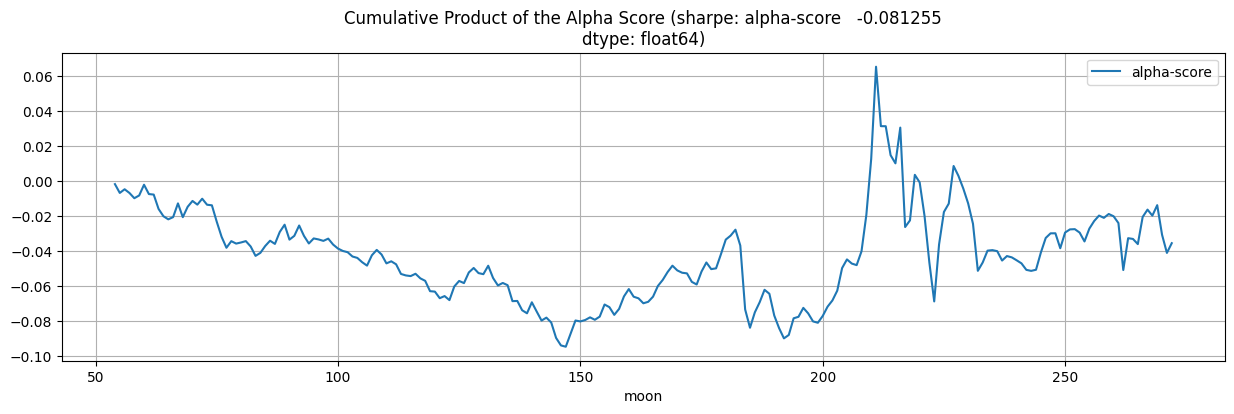

In [25]:
# Show the cumulative product of the alpha score
cumprod.plot(title=f'Cumulative Product of the Alpha Score (sharpe: {sharpe})', figsize=(15, 4), grid=True)
plt.show()

This vanilla batched boosting estimator doesn't seem to perform here. Try to find a better model!

# Test your model

In [ ]:
crunch.test()

# Submit your model

## Through the API

In [26]:
# Save the libraries in a requirements.txt file 
libraries = ['joblib', 'pandas', 'numpy', 'xgboost', 'readwrite', 'tqdm', 'matplotlib']
with open('requirements.txt', 'w') as f:
    for lib in libraries:
        f.write(f"{lib}\n")

In [27]:
# NOTE: this cell does not work in Google Colab

# Convert the notebook to a .py file
!crunch convert --override quickstarter.ipynb main.py
# Push your code to the platform
!crunch push --message "Quickstarter datacrunch"

convert cell_0 skip since not code: markdown
convert cell_1 skip since not code: markdown
convert cell_2 skip since not code: markdown
convert cell_3 skip since not code: markdown
convert cell_4 skip since empty (without !bash, %magic and #comment)
convert cell_5 skip since not code: markdown
convert cell_6 skip since not code: markdown
convert cell_7 skip since empty (without !bash, %magic and #comment)
convert cell_8 used 9/9 node(s)
convert cell_9 skip since not code: markdown
convert cell_10 skip since no valid node
convert cell_11 skip since not code: markdown
convert cell_12 skip since not code: markdown
convert cell_13 used 1/1 node(s)
convert cell_14 skip since not code: markdown
convert cell_15 skip since not code: markdown
convert cell_16 used 1/1 node(s)
convert cell_17 skip since not code: markdown
convert cell_18 skip since no valid node
convert cell_19 used 1/1 node(s)
convert cell_20 skip since not code: markdown
convert cell_21 skip since no valid node
convert cell_22 s

## Through the website

Deposit this notebook in the submit window of the competition: https://hub.crunchdao.com/competitions/datacrunch-rally/submit/via/notebook